# COGS 108 - EDA Checkpoint

# Names

* Sean Hwang
* Minhan Lee
* Giho Kim
* Teahyung Kim

# Table of Content

* Research Question
* Setup
* Data Cleaning
  * English Premier League Dataset
  * European Soccer Dataset
* EDA
  * By Continent
  * By Overall Height Distribution
  * By Weight

<a id='research_question'></a>
# Research Question

Is there a relationship between the height of the soccer players and their entrance to the English premier league and their performance?

We will analyze the trends of the height of all positions in the English premier league from the 1950s.

Also, we will analyze existing professional goalkeepers' height and performance ratings measured by FIFA, international Football Association.

# Setup

In [2]:
pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
""" Bulitins """
import json
import sqlite3
import zipfile
import datetime
import time

""" Third Party """
# import pycountry_convert
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Data Cleaning

Here are some common functions to normalize our data into consistent format

In [13]:
def extract_year(birth):
    if isinstance(birth, float) or isinstance(birth, int):
        try:
            return int(birth)       # 1950
        except:
            return np.nan
    if birth.count("/") == 2:
        try:
            return int(birth[:4])   # All '%Y/%m/%d' format
        except:
            return int(birth[-4:])  # All '%d/%m/%Y' format
    return np.nan

# See https://www.guidetofootball.com/tactics/playing-positions/ for more info
def clean_position(d):
    if 'GK' == d:    # GK
        return 'GK'
    elif 'B' in d:   # CB, LB, RB
        return 'DF'
    elif 'M' in d:   # CM, LM, LCM, LDM
        return 'MF'
    else:            # CS, LS, RS
        return 'FW'


## English Premier League Dataset

This data provides information of soccer players who played in the English premier League from 1880 to 2021. The dataset includes players’ year of birth, height, and positions. Our research will mainly focus on datasets of players from 1950 to 2021 and their height and positions to determine the overall trend of change in player’s height and its difference by positions. This data will be compared and analyzed to other datasets of player’s of different regions or league

In [3]:
""" 1. Download data (Worldfootball Player Height Data) """
with open("./crawler.py", "r") as f:
  file = f.read()

In [4]:
print("Loading Historical Height Data")
with open("players.json", "r") as f:
  player_history = pd.DataFrame(json.load(f), columns=["name", "year", "team", "birth", "height", "position"])
print(player_history.describe)
print(player_history.head())

Loading Historical Height Data
<bound method NDFrame.describe of                    name  year                     team       birth  height  \
0        Norman Nielson  1950        Charlton Athletic  06/12/1928     191   
1            John Hewie  1950        Charlton Athletic  13/12/1927     188   
2         Jackie Vernon  1950     West Bromwich Albion  26/09/1918     186   
3        Colin McDonald  1950               Burnley FC  15/10/1930     184   
4           Bill Slater  1950             Blackpool FC  29/04/1927     184   
...                 ...   ...                      ...         ...     ...   
26622      Aaron Lennon  2021               Burnley FC  16/04/1987     165   
26623     Tariq Lamptey  2021   Brighton & Hove Albion  30/09/2000     164   
26624       Ryan Fraser  2021         Newcastle United  24/02/1994     163   
26625        Oscar Bobb  2021          Manchester City  12/07/2003     162   
26626  Dexter Lembikisa  2021  Wolverhampton Wanderers  04/11/2003     160   

In [5]:
player_history.columns = list(map(str.lower, player_history.columns))
player_history.reset_index(inplace = True, drop = True)
player_history.head()
player_history.year.describe()
player_history['birth'] = player_history['birth'].apply(extract_year)
player_history['age'] =  player_history['year'] - player_history['birth']

## European Soccer Dataset

Download zip of European Soccer dataset manually from https://www.kaggle.com/stefanoleone992/fifa-21-complete-player-dataset

This dataset provides all the information of more than 8,000 players extracted from the last editions of FIFA Series from 2015 to 2021. The dataset includes players’ information of weight, height, nationality, age, and position.  This dataset will be merged with the Dataset of Premier League from 1950 to help determine the overall trend of change in English Premier League’s soccer players’ height from 1950 to 2021. This data will be used to help answer our research question on the player’s attributes such as height and see if a certain range of height influences the player’s overall rating. Further, we will visualize this trend in height by positions to see how significant height is in each position.

In [6]:
""" Load data from SQlite and json and Convert to Dataframe """
# Unzip sqlite file (Uncompressed File is large for git)
with zipfile.ZipFile("./data/archive.zip", 'r') as zip_ref:
  zip_ref.extractall("./data")

Removing all the unimportant columns from the dataset.

In the players' postition column, the original dataset has very specific position values such as "CAM" or "CDM". To normalize, we change the values include "B" (stands for Back) to "DF" (Defender), value include "M" (stands for Middle) to "MF" (MID )

In [7]:
ignore_columns = ['short_name', 'sofifa_id', 'player_url', 'potential', 'value_eur', 'club_jersey_number', 'club_loaned_from', 'club_joined',
 'wage_eur','international_reputation','weak_foot','skill_moves','work_rate','body_type', 'real_face','release_clause_eur',
 'player_tags', 'nation_jersey_number','pace','shooting', 'nationality_id', 'goalkeeping_speed', 'gk', 'club_team_id',
 'passing', 'dribbling', 'defending', 'physic', 'club_contract_valid_until', 'nation_team_id', 'defending_marking_awareness',
 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power',
 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle',
 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
 'goalkeeping_reflexes', 'ls', 'st', 'rs', 'lw', 'lf', 'cf','rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb',
 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'preferred_foot', 'nation_position',
 'player_face_url', 'club_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url', 'club_position']


df = {}

for y in range(2016, 2022):
    df[f"m{y}"] = pd.read_csv(f"./data/players_{str(y % 100)}.csv", low_memory=False).drop(columns = ignore_columns)
    df[f"m{y}"]['year'] = y
    df[f"m{y}"]['player_positions'] = df[f"m{y}"]['player_positions'].apply(clean_position)
    df[f"m{y}"]['gender'] = "male"

    df[f"f{y}"] = pd.read_csv(f"./data/female_players_{str(y % 100)}.csv", low_memory=False).drop(columns = ignore_columns)
    df[f"f{y}"]['gender'] = "female"
    df[f"f{y}"]['player_positions'] = df[f"f{y}"]['player_positions'].apply(clean_position)
    df[f"f{y}"]['year'] = y

We merge the values of dataset and change the column names to easier understandable names.

In [8]:
players = pd.concat(df.values())
players.columns = list(map(str.lower, players.columns))
players.rename(columns = {'long_name':'name', 'club_name': 'team', 'dob': 'birth', 'weight_kg': 'weight', 'height_cm':'height', 'player_positions':'position'}, inplace = True)
players.reset_index(inplace = True, drop = True)
players.head()
players.shape

(108538, 13)

In [19]:
# Clean up Age
players['birth'] = players['birth'].apply(extract_year)
players['league_level'] = pd.to_numeric(players['league_level'], downcast="integer", errors='coerce')
players['age'] = players['year'] - players['birth']

# EDA

These are two main dataframe that we will explore deeply.

`player_history` Dataframe only contains year and height information to give overall changes in height

`players` Dataframe contains many other information, so we could perform multiple analysis and factors that affect performance

In [20]:
display(player_history.columns)
display(player_history.describe())
display(players.columns)
display(players.describe())

Index(['name', 'year', 'team', 'birth', 'height', 'position', 'age'], dtype='object')

,year,birth,height,age
count,26627.000000,26626.000000,26627.000000,26626.000000
mean,1997.017426,1972.299557,180.984940,24.718846
std,17.357342,17.634855,6.787984,4.867388
min,1950.000000,1911.000000,160.000000,9.000000
25%,1988.000000,1963.000000,176.000000,21.000000
50%,2000.000000,1975.000000,180.000000,24.000000
75%,2011.000000,1986.000000,186.000000,28.000000
max,2021.000000,2005.000000,205.000000,49.000000


Index(['name', 'position', 'overall', 'age', 'birth', 'height', 'weight',
       'team', 'league_name', 'league_level', 'nationality_name', 'year',
       'gender'],
      dtype='object')

,overall,age,birth,height,weight,league_level,year
count,108538.000000,0.0,0.0,108538.000000,108538.000000,104970.000000,108538.000000
mean,66.153172,NaN,NaN,180.996996,75.033712,1.383033,2018.592143
std,7.140939,NaN,NaN,6.910058,7.200506,0.750186,1.691707
min,44.000000,NaN,NaN,152.000000,45.000000,1.000000,2016.000000
25%,62.000000,NaN,NaN,176.000000,70.000000,1.000000,2017.000000
50%,66.000000,NaN,NaN,181.000000,75.000000,1.000000,2019.000000
75%,71.000000,NaN,NaN,186.000000,80.000000,2.000000,2020.000000
max,94.000000,NaN,NaN,208.000000,110.000000,4.000000,2021.000000


## By Continent and League

There are multiple leagues and players from all around the world.

First we will explore distribution of individual league and their levels using word map.

,league_level,percentage (%)
1.0,78165,72.016252
2.0,17135,15.787098
3.0,5938,5.470895
4.0,3732,3.438427


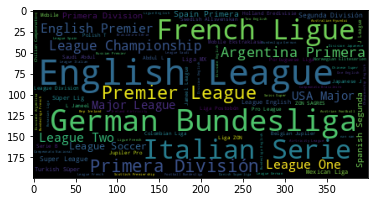

In [40]:
league_cloud = WordCloud().generate(' '.join(map(str, players.league_name)))
league_level_df = players.league_level.value_counts().to_frame()
league_level_df['percentage (%)'] = league_level_df.apply(lambda l: l / len(players) * 100)
display(league_level_df)

plt.figure()
plt.imshow(league_cloud)

Most of our data consists of legaue level 1 which is more than 70% of our data.

We can see there most of them are from European leagues but we can see few legaues from other contitnents such as Argentina nad USA League.

  Note, English League is exonym (identical) for Premier League.

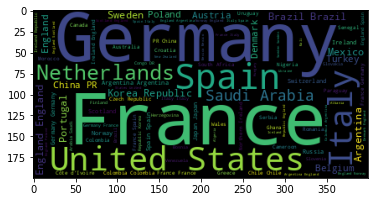

In [41]:
nationality_cloud = WordCloud().generate(' '.join(players.nationality_name).strip())

plt.figure()
plt.imshow(nationality_cloud)

Even though most of the leagues are European, we can see more diversity in our players nationality, because there are many expatriate people in each league.

## By Height

Carry out EDA on your dataset(s); Describe in this section

Using a line plot, we visualized the change in numbers of players by positions from 1950 to 2021. We found that, in all positions, the number of players increased. However, we noticed numbers of MF and DF players increased significantly the most while GK increased the least. We can assume that the reason why GK increased the least is only one GK is needed for playing.

Text(0, 0.5, 'count')

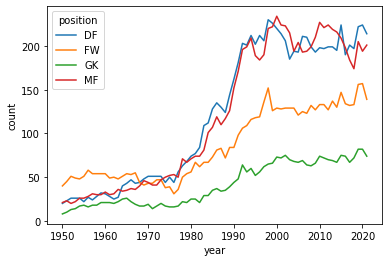

In [12]:
# counts per position by year (epl male 1950-2021)

grouped_by_year_position = player_history.groupby(["year", "position"]).count().reset_index()
p = sns.lineplot(data=grouped_by_year_position, x="year", y="name", hue = "position")
p.set_ylabel("count")

To visualize the recent trend of numbers of players by positions in different genders, we again used lineplot and found that in both gender the positions of DF and MF were noticeably two greatest in numbers. In both gender, the numbers of DF and MF exceeds those of GK and FW approximately by 2 to 3 times, and their line plot showed similar trend. 

<AxesSubplot:xlabel='year', ylabel='name'>

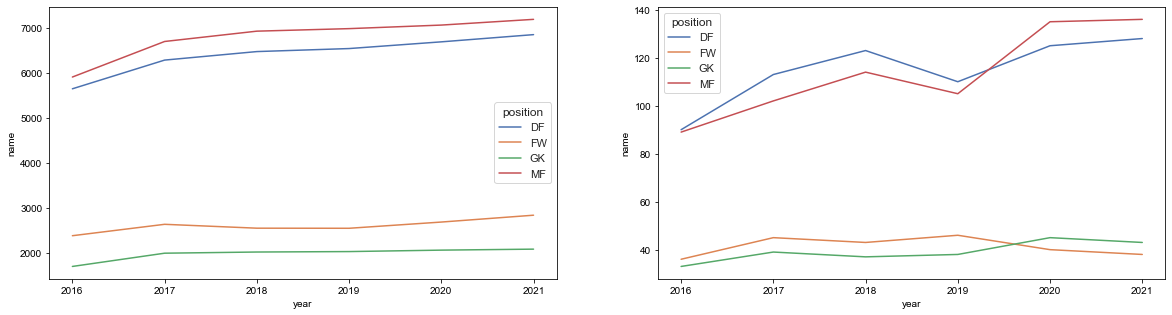

In [13]:
male = players[players['gender'] == 'male']
female = players[players['gender'] == 'female']

grouped_male_count = male.groupby(["year", "position"]).count().reset_index()
grouped_female_count = female.groupby(["year", "position"]).count().reset_index()

fig, ([ax1, ax2]) = plt.subplots(ncols = 2, nrows = 1, sharey = False, figsize=(20,5))
sns.set(font_scale=1, style="white")

sns.lineplot(x="year", y="name", ax = ax1, hue = "position", data = grouped_male_count)
sns.lineplot(x="year", y="name", ax = ax2, hue = "position", data = grouped_female_count)

After finding the trend of numbers of players by positions, we are interested in the change of the average height of players by different positions from 1950 to 2020. Looking at the line plots below, we found overall increase in average height of soccer players in every positions. Yet, we also noticed the average height of GK increased most rapidly in the last 50 years.

Text(0, 0.5, 'Avg Height')

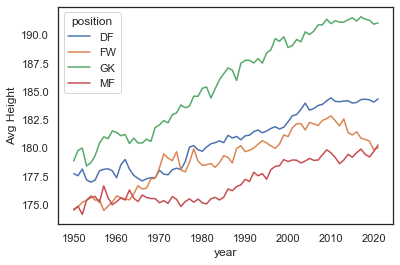

In [14]:
# avg height per position by year (epl male 1950-2021)
grouped_by_year_height = player_history.groupby(["year", "position"]).mean().reset_index()
p = sns.lineplot(data=grouped_by_year_height, x="year", y="height", hue = "position")
p.set_ylabel("Avg Height")

The two plots below indicate the trend of average hieght of soccer players in the world leagues from 2016 to 2021. The one on the left represents the trend of the male and the other represents that of female. Looking at the graph, we found that the average height of soccer players was taller in the order of Goalkeeper(GK), Defender(DF), Foward(FW), and Midfielder(MF) in both gender. However, there were no significant change in average height in every positions from 2016 to 2021.    

<AxesSubplot:xlabel='year', ylabel='height'>

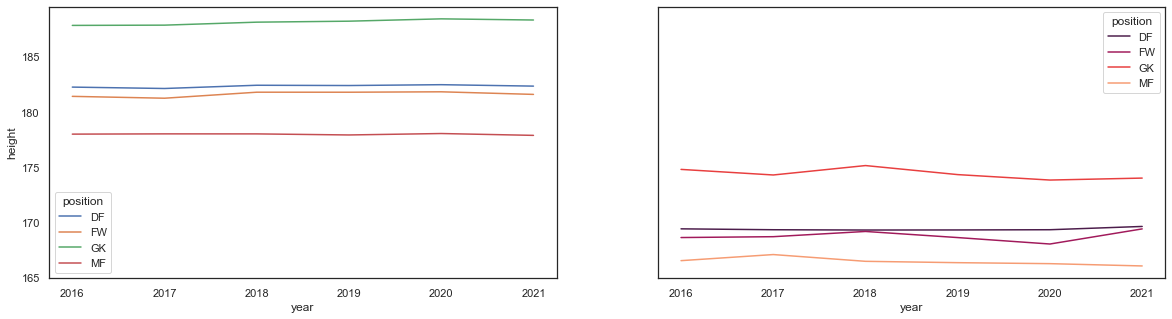

In [15]:
grouped_male_position = male.groupby(['position', 'year']).mean().reset_index()
grouped_female_position= female.groupby(['position', 'year']).mean().reset_index()

fig, ([ax1, ax2]) = plt.subplots(ncols = 2, nrows = 1, sharey = True, figsize=(20,5))
sns.set(font_scale=1, style="white")

sns.lineplot(x = "year", y = "height", ax = ax1, hue = "position", data = grouped_male_position)
sns.lineplot(x = "year", y = "height", ax = ax2, hue = "position", data = grouped_female_position, palette = "rocket")

In order to visualize the change in height of male soccer players by decades in Enlgish premier League from 1950s to 2020s, we used several botplots to see the difference in height by decades. From the plots, we found that from 1950, the hieght of male players in EPL steadily increased by loooking at increase in 25th, median, and 75th percentile of height of soccer players in every decades. 

Text(0, 0.5, 'height')

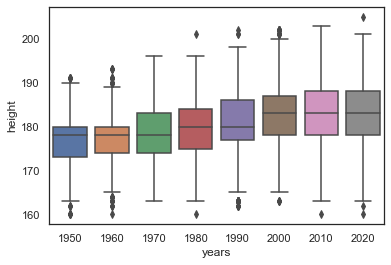

In [16]:
# box plot of height by decade (male epl 1950 - 2020)
player_history['year_range'] = player_history['year'].apply(lambda y: y // 10 * 10)

p = sns.boxplot(x="year_range", y="height", data=player_history)
p.set_xlabel("years")
p.set_ylabel("height")

We further visualized the difference in height of soccer players in every positions by using box plot. We realized the height of GK is noticeably taller that other positions by looking at their 25th percentile of hieght is about the same to that of 75th percentile of FW and DF and even taller than 75th percentile of MF. 

Text(0, 0.5, 'height')

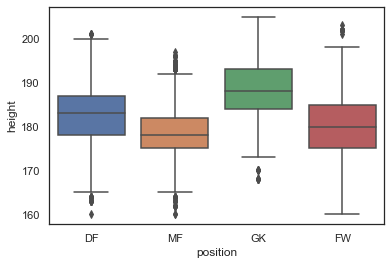

In [17]:
# boxplot of height in different position
ax = sns.boxplot(x="position", y="height", data=player_history)
ax.set_xlabel("position")
ax.set_ylabel("height")

We made a age_range_converter to make age_range in our data

In [32]:
def age_range_converter(age):
    if age < 26:
        return "- 25"
    elif age < 31:
        return "26 - 30"
    elif age < 36:
        return "31 - 35"
    elif age < 41:
        return "36 - 40"
    elif age < 46:
        return "41 - 45"
    else:
        return "45 - "
    
players['age_range'] = players['age'].apply(age_range_converter)

We visulaized the line chart to see if there is the relationship between the age-range of soccer players and the average height of soccers players by decades. As shown in previous graphs, we found the increase in  average height in recent decades of every age-range of soccer players. We also realized the overall trend of height increased for the players of older age. We speculate that the taller players are, the longer they play as an athlete and eligible to play in recent decades.

<AxesSubplot:xlabel='age_range', ylabel='height'>

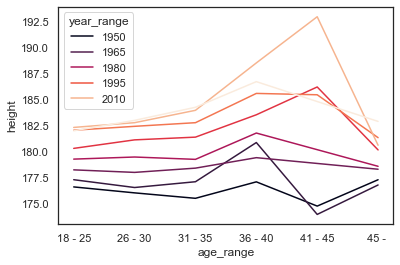

In [19]:
player_history['age_range'] = player_history['age'].apply(age_range_converter)
groupby_age_range_1950 = player_history.groupby(["age_range", 'year_range']).mean().reset_index()
sns.lineplot(data = groupby_age_range_1950, x = "age_range", y = 'height', hue = 'year_range', palette='rocket')

Text(0.5, 1.0, 'Height(cm) vs. Performance Score')

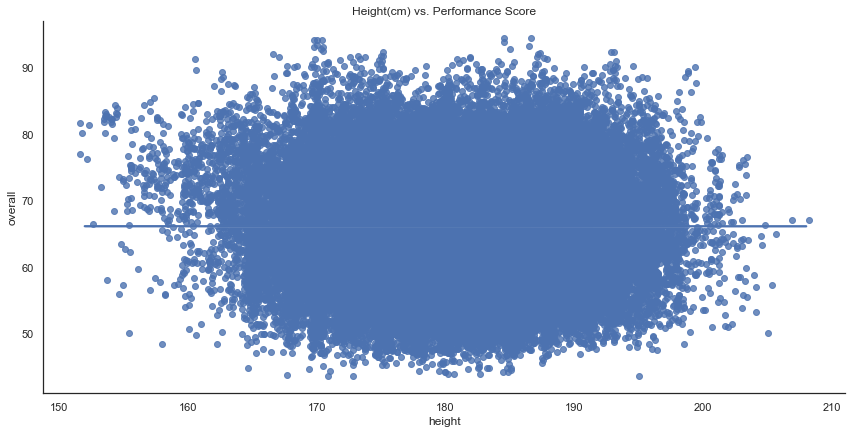

In [20]:
sns.lmplot(data = players, x = 'height', y = 'overall', height=6, aspect=2, 
           x_jitter=0.5, y_jitter=0.5)
plt.title('Height(cm) vs. Performance Score')

Based on the plot that shows relationship between height and player's overall performance, we can find out that two values does not have significant relationship. However, as other factors might affect soccer players' performance which makes no relationship between height and players' overall performance, we have to perform more experiments and analysis to discover how much significance does height have on players' performance.

Continent 

## By Weight

Text(0.5, 1.0, 'Weight(kg) vs. Performance Score')

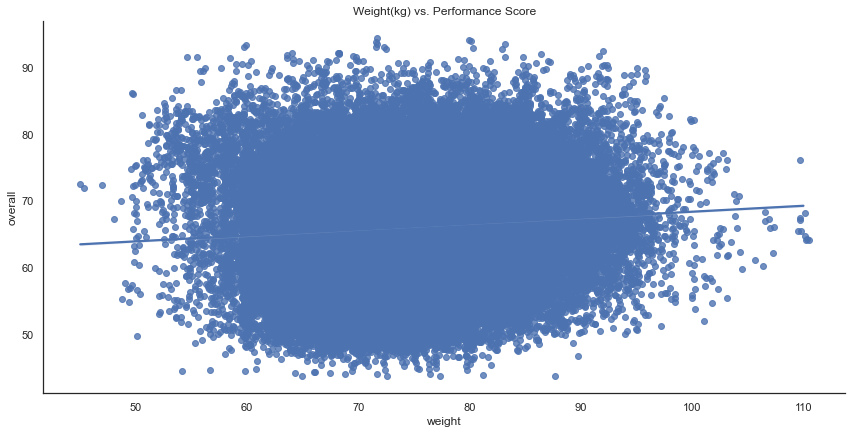

In [21]:
sns.lmplot(data = players, x = 'weight', y = 'overall', height=6, aspect=2, x_jitter=0.5, y_jitter=0.5)
plt.title('Weight(kg) vs. Performance Score')

From the plot above, we can observe that the line is slightly positive which indicates that weight of soccer players and their performance has positive correlation. This result was not expected since we thought that as the weight of player increases the performance would decrease because we thought heavier weights would bother player's movement. We will perform more experiments to find out whether the weight of player is significant in deciding performance of players.

In [27]:
def performace_f(x, low_perf, high_perf):
    if x >= high_perf:
        return 'high performance'
    elif x < high_perf and x > low_perf:
        return 'middle performance'
    else:
        return 'low performance'

In [28]:
low_perf = np.percentile(players['overall'].dropna(), 25)
high_perf = np.percentile(players['overall'].dropna(), 75)
players['performance'] = players['overall'].dropna().apply(performace_f, args=(low_perf, high_perf))

<AxesSubplot:xlabel='weight', ylabel='Count'>

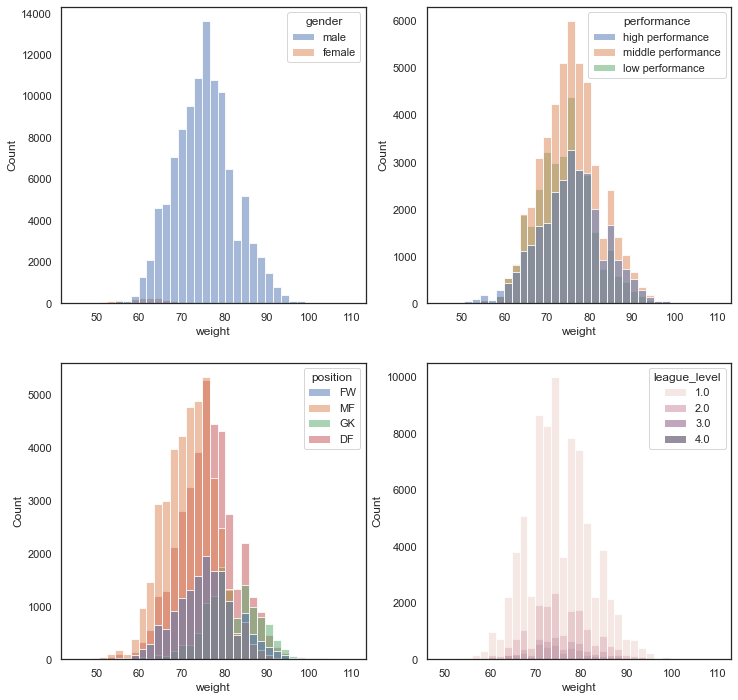

In [29]:
fig, axes  = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
sns.histplot(players, x='weight', bins = 35, hue = "gender", ax=axes[0,0])
sns.histplot(players, x='weight', bins = 35, hue="performance", ax=axes[0,1])
sns.histplot(players, x='weight', bins = 35, hue="position", ax=axes[1,0])
sns.histplot(players, x='weight', bins = 35, hue="league_level", ax=axes[1,1])

If we look at the distribution of weights and compare the distribution based on different groups (gender, performance, position, and league_level), we can observe that distribution of weights grouped by performance and league_level has no difference between each of groups. However, when distribution is grouped by gender and position of players, we can find out different. Since it is usual that women has less weight than men, distribution of weights of players grouped by gender shows significant difference. Also, we can know that weight of goalkeepers is usually heavier than players at other positions. This is because usually goalkeepers are taller than any other players which is shown in the above plot.

Text(0, 0.5, 'Avg Weight')

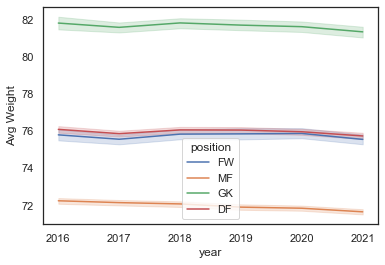

In [25]:
p = sns.lineplot(data=players, x="year", y="weight", hue = "position")
p.set_ylabel("Avg Weight")

Above plot shows that there are no big differnce of weight change of soccer players over few years. This indicates that there is no need for players to lose or increase their weight and weight does not affect players' entrance to the English premier league.